Predicting the number of total bike users using Linear regression . Here I use Ridge algorithems  to model a multivariant problem. I did not make the time series stationary.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from yellowbrick.regressor import residuals_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

df1=pd.read_csv('day.csv', parse_dates=['dteday'])
df1

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Drop some unnecessary data

In [2]:
df1=df1.drop(['instant','casual','registered'], axis=1)

Plot histograms

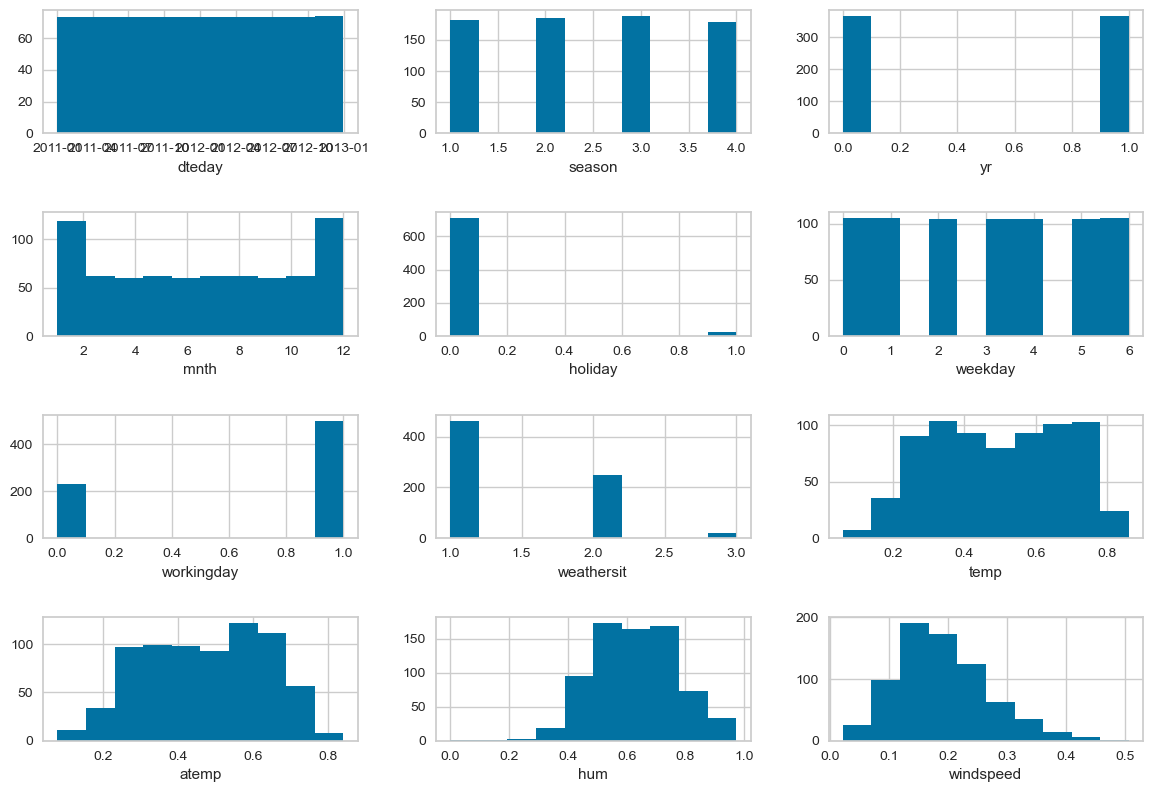

In [3]:
fig=plt.figure(figsize=(12,10))
count=0
for i in range(4):
    for j in range(3):
        plt.subplot2grid((5,3),(i,j))
        plt.hist(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1


Plot box

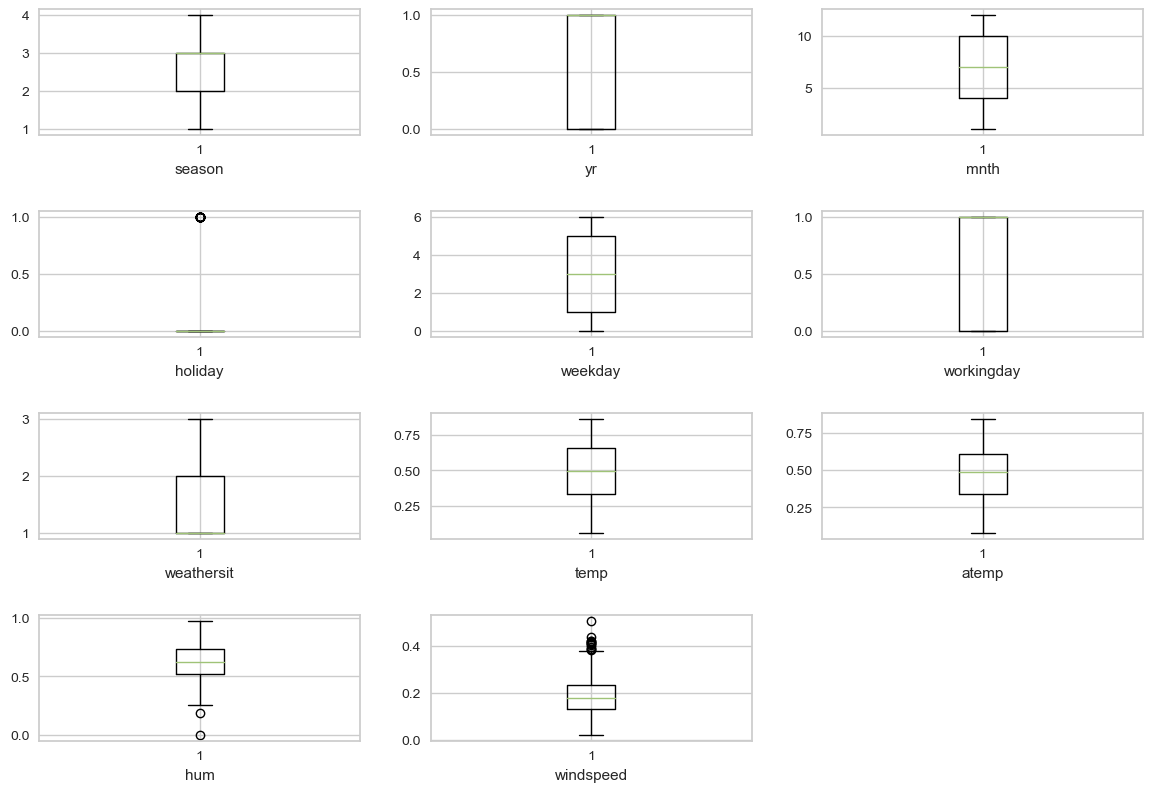

In [4]:
fig=plt.figure(figsize=(12,10))
count=1
for i in range(4):
    for j in range(3):
        if count== 12:
            break
        plt.subplot2grid((5,3),(i,j))
        plt.boxplot(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1

Check if there is any duplicated data

In [5]:
df1.duplicated().sum()

0

Check if there is any nun value

In [6]:
df1.isna().sum()


dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Plot heatmap of correlation between features. As expected there is a large corelation between temperature and apperent temperature

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_26726/291388897.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor, dtype=np.bool))


<AxesSubplot:>

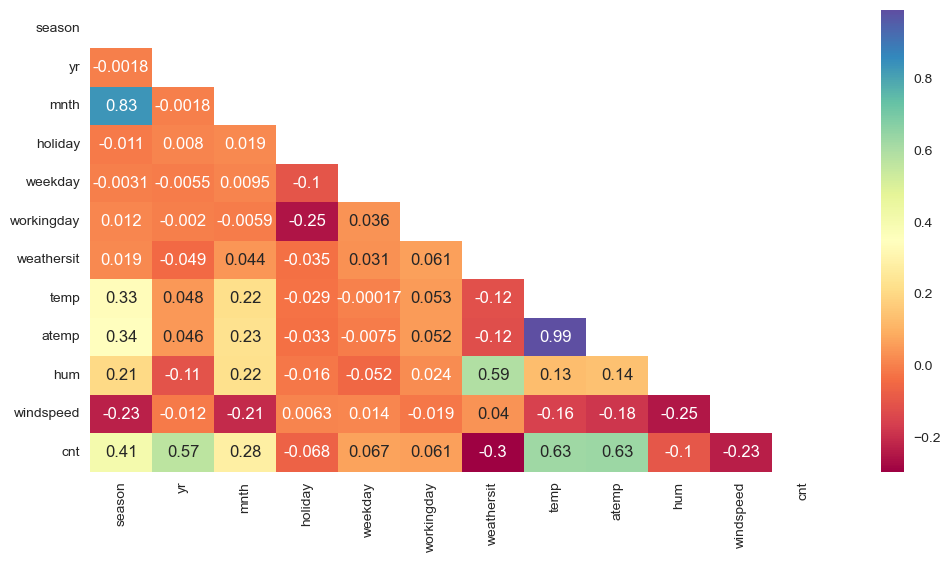

In [7]:
cor=df1.corr()
mask = np.triu(np.ones_like(cor, dtype=np.bool))
fig=plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Spectral', mask=mask , annot=True)


Let's drop atemp from dataset and start spliting the data

In [8]:
df_r=df1.drop('atemp',axis=1)


In [9]:
df1['dteday'].describe()

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_26726/916621911.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1['dteday'].describe()


count                     731
unique                    731
top       2011-01-01 00:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-31 00:00:00
Name: dteday, dtype: object

I select the train to be from the first of 2011 till first of May 2012 and the rest of months of 2021 serves as test dataset

In [10]:
df1=df1.set_index('dteday')

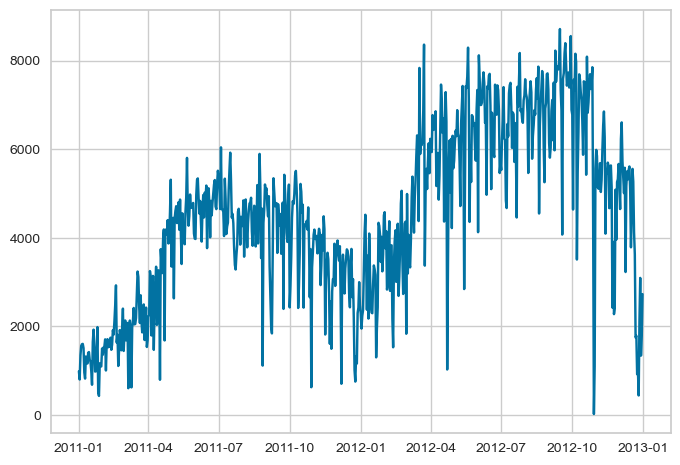

In [11]:
plt.plot(df1.index, df1['cnt'])


In [12]:
df1

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114
2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095
2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341


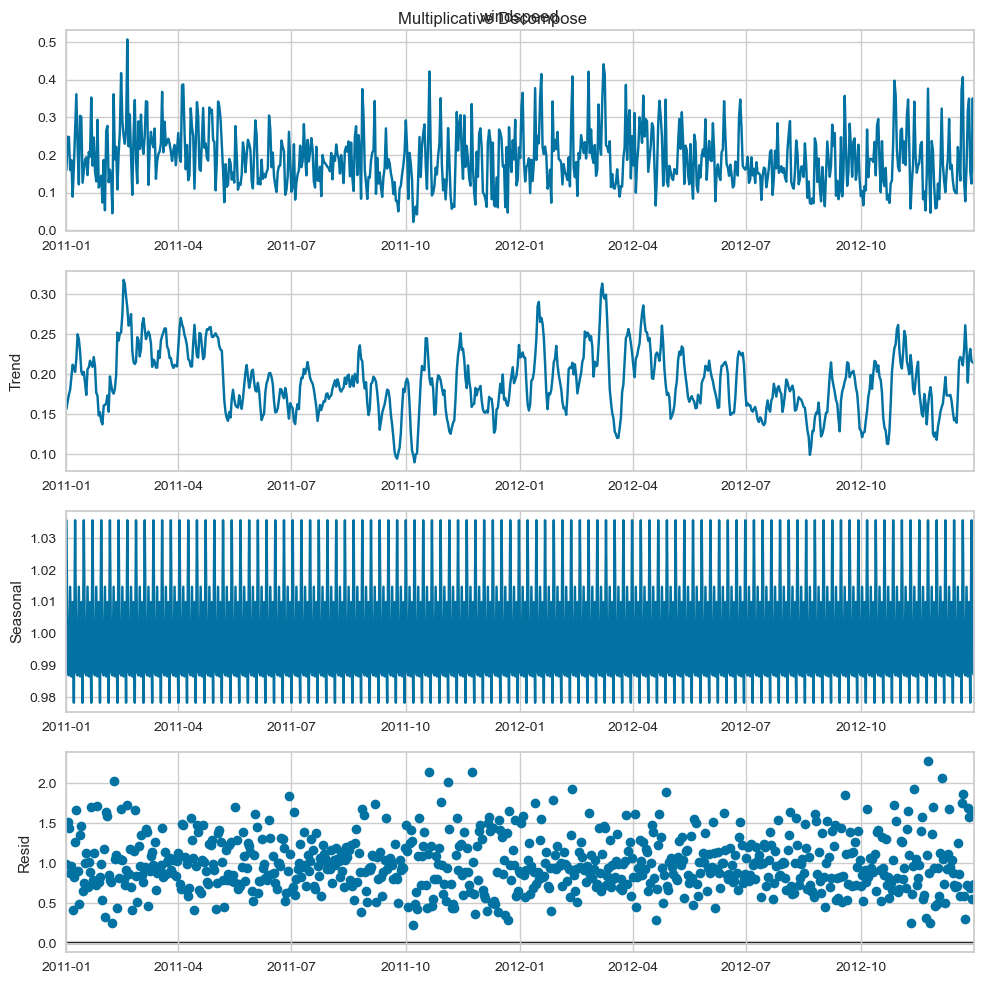

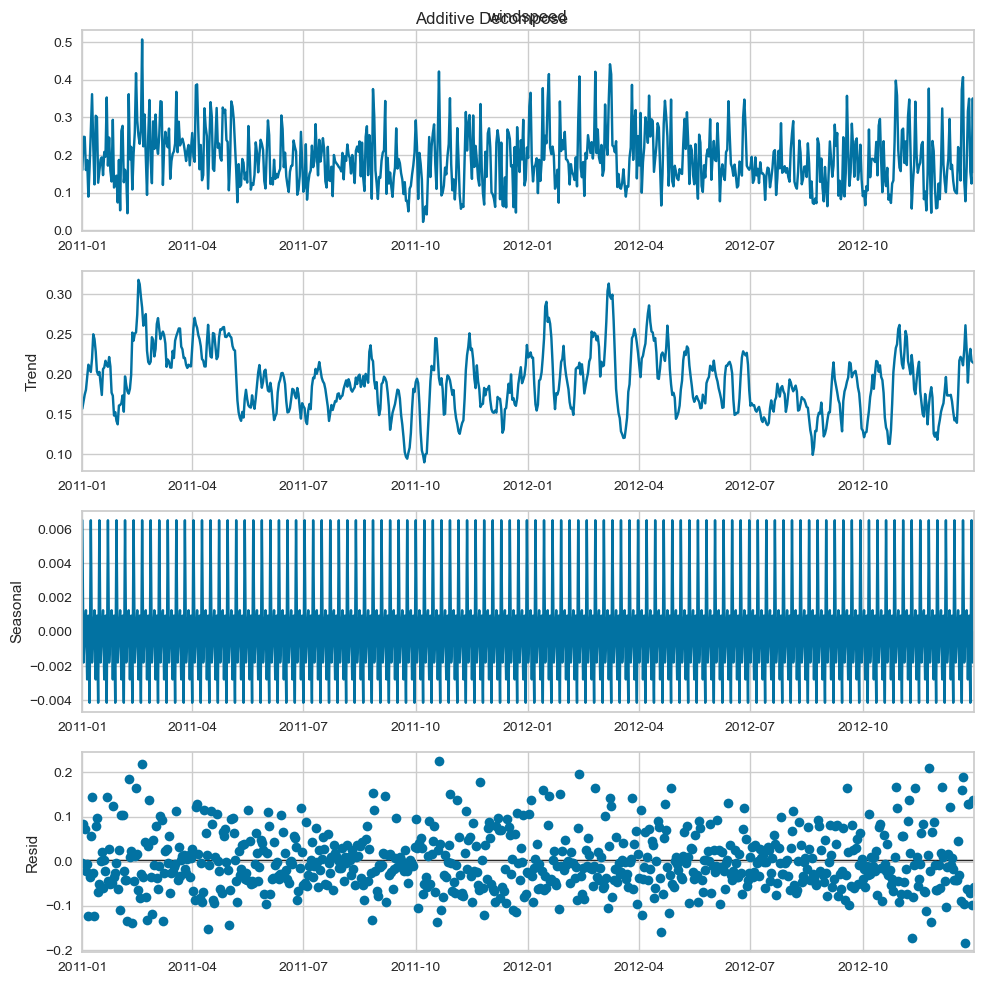

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
df1.sort_index(inplace=True),
# Import Data

# Multiplicative Decomposition 
result_mul_m = seasonal_decompose(df1['windspeed'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add_m = seasonal_decompose(df1['windspeed'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul_m.plot().suptitle('Multiplicative Decompose', fontsize=12)
result_add_m.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

[]

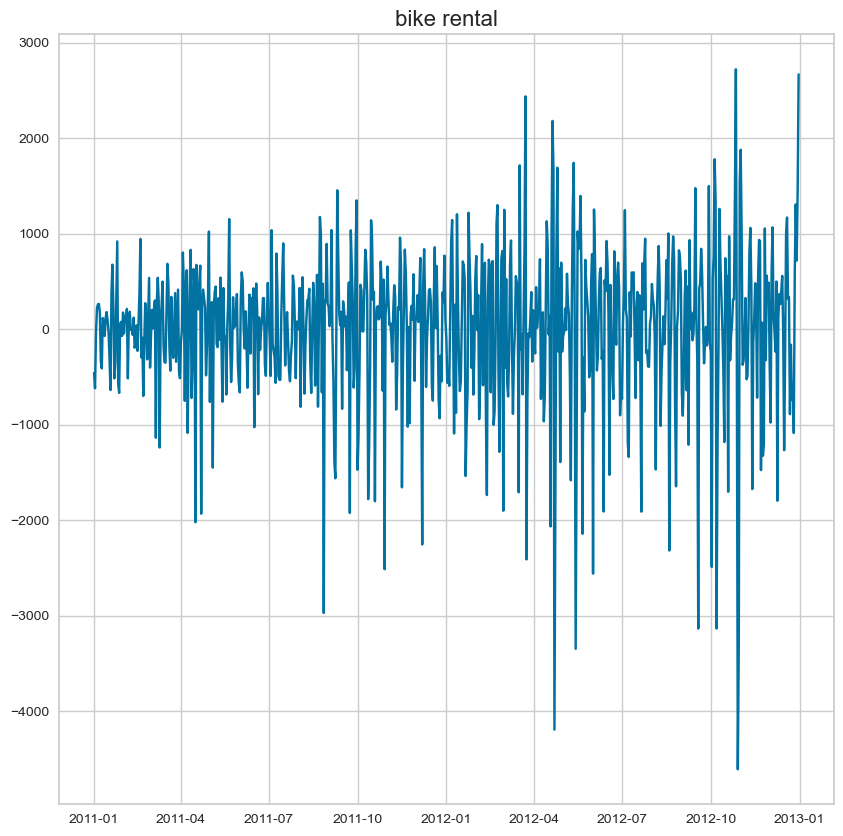

In [14]:
# Time Series Decomposition
result_mul_m = seasonal_decompose(df1['cnt'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
detrend_df= df1.cnt.values - result_mul_m.trend

# Plot
plt.plot(detrend_df)
plt.title('bike rental', fontsize=16)
plt.plot()

[]

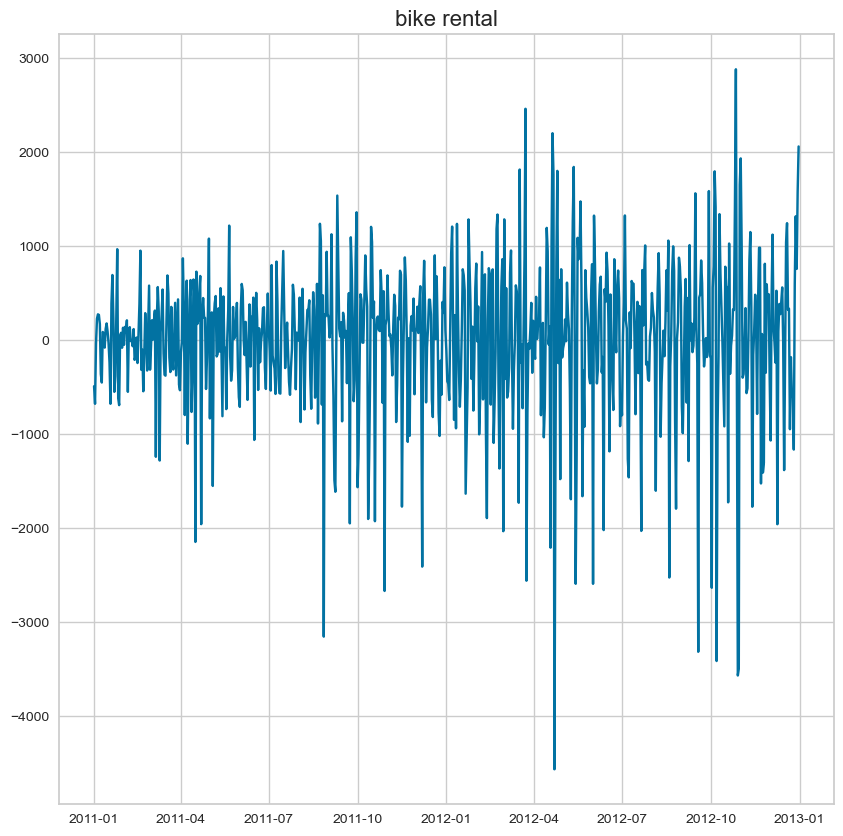

In [15]:
# Time Series Decomposition
result_mul_m = seasonal_decompose(df1['cnt'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseason_df= detrend_df.values/ result_mul_m.seasonal

# Plot
plt.plot(deseason_df)
plt.title('bike rental', fontsize=16)
plt.plot()

In [16]:
df_r=df_r.set_index(df_r['dteday'])
df_r=df_r.drop('dteday', axis=1)


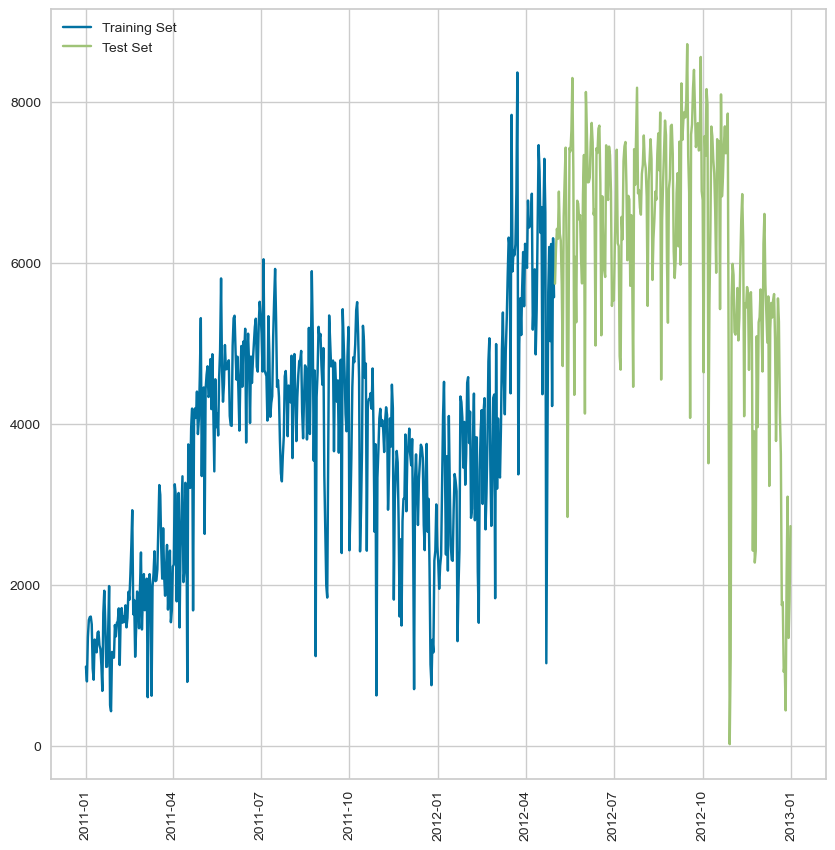

In [17]:
train=df_r[df_r.index < '05-01-2012']
test= df_r[df_r.index >= '05-01-2012']
plt.plot(train.index, train['cnt'])
plt.plot(test.index, test['cnt'])
plt.xticks(rotation=90)
plt.legend(['Training Set', 'Test Set'])

plt.show()

In [18]:
deseason_df

dteday
2011-01-01    -488.328825
2011-01-02    -675.089859
2011-01-03     -37.540021
2011-01-04     229.481624
2011-01-05     276.318760
                 ...     
2012-12-27     600.390612
2012-12-28    1319.310491
2012-12-29     759.540306
2012-12-30    1579.795399
2012-12-31    2061.501837
Name: seasonal, Length: 731, dtype: float64

Plotting cross-validation 

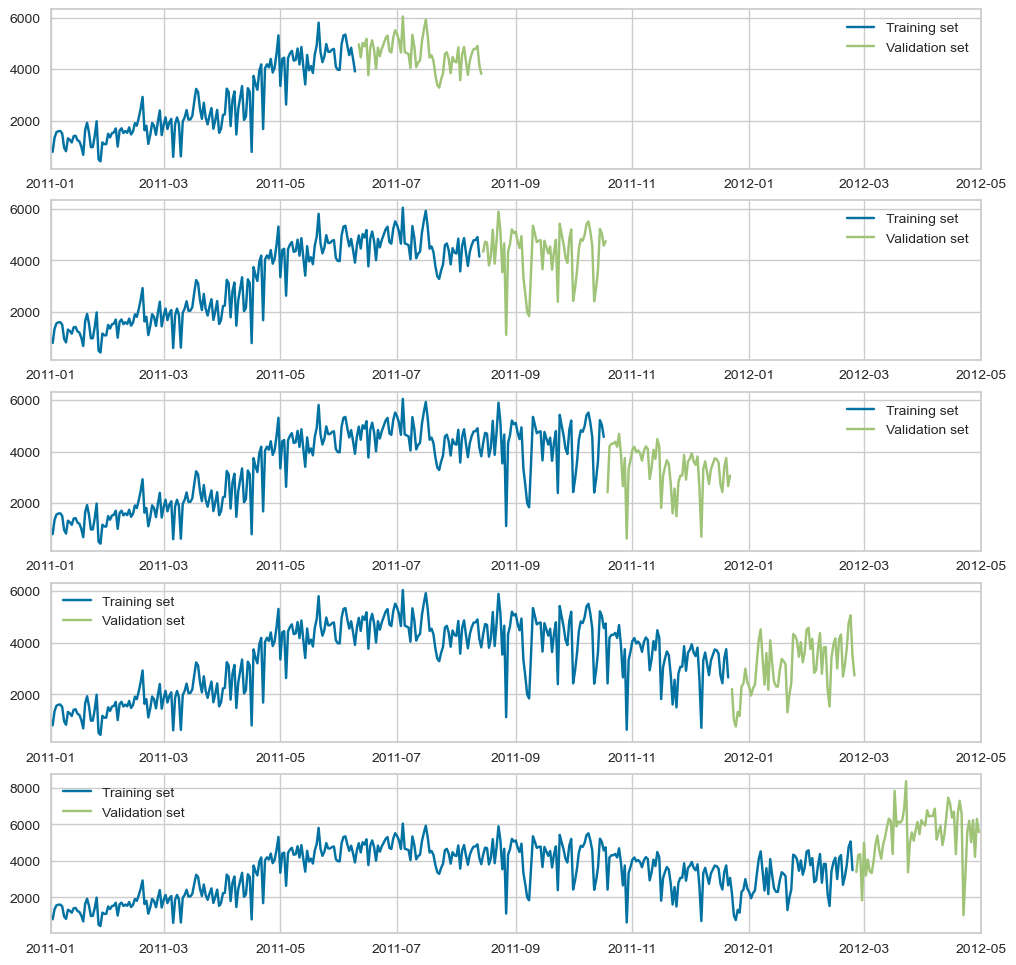

In [19]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()
fig=plt.figure(figsize=(12,12))

count=0
for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    plt.subplot2grid((5,1),(count,0))
    plt.plot(train_valid.index, train_valid['cnt'])
    plt.plot(validation.index,validation['cnt'])
    plt.legend(['Training set','Validation set'])
    plt.xlim([dt.date(2011, 1, 1), dt.date(2012, 5, 1)])
    count+=1

plt.show()

function for plotting learning curve

In [20]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 20)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring= "neg_mean_absolute_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylabel('neg_mean_absolute_error')

    plt.legend(loc="best")
    return plt

Define x and y and fit the model and find MSE and R2 scores

MAE is 1116.4475
R square is 0.8512
MAE is 982.8518
R square is 0.8039
MAE is 838.6810
R square is 0.7771
MAE is 1335.9921
R square is 0.7558
MAE is 1268.7357
R square is 0.7521


<module 'matplotlib.pyplot' from '/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

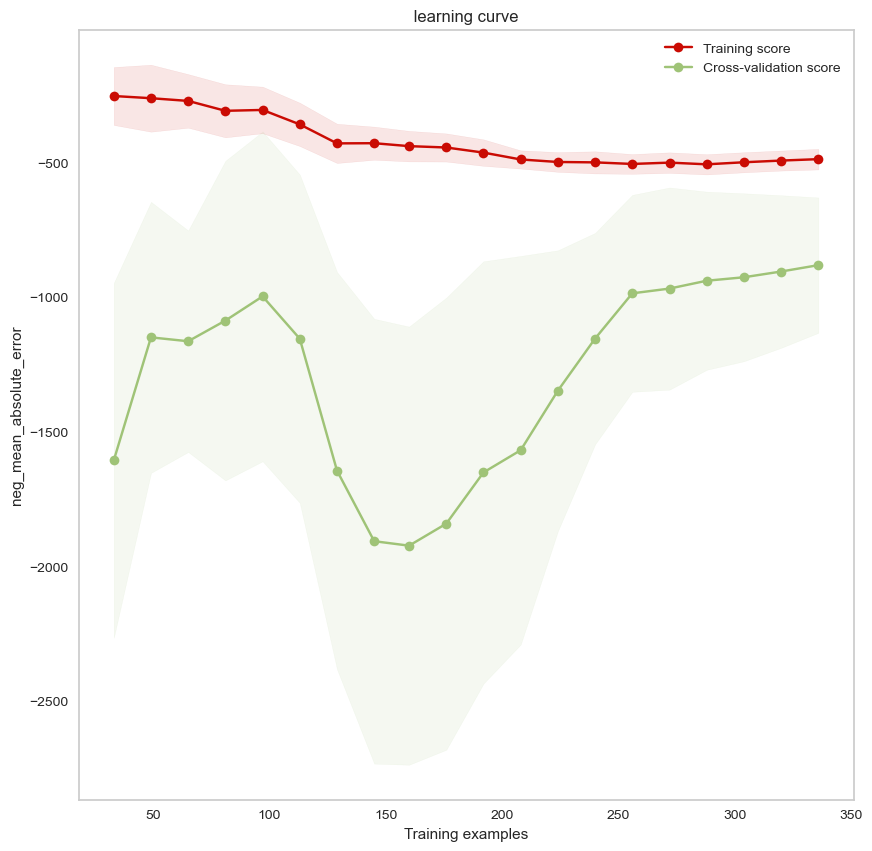

In [21]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    y_train=train_valid['cnt']
    y_val=validation['cnt']
    x_train=train_valid.drop('cnt', axis=1)
    x_val=validation.drop('cnt', axis=1)
    model=Ridge()
    model.fit(x_train, y_train)
    print('MAE is {}'.format('%.4f' %mean_absolute_error(y_val, model.predict(x_val)) ))
    print('R square is {}'.format('%.4f' %model.score(x_train,y_train)))

plot_learning_curve(estimator = model,title = " learning curve ",X = x_train, y = y_train, cv = 5)


In [22]:
x_train_total=train.drop('cnt', axis=1)
y_train_total=train['cnt']
x_test=test.drop('cnt',axis=1)
y_test=test['cnt']
model.fit(x_train, y_train)
print('MAE is {}'.format('%.4f' %mean_absolute_error(y_test, model.predict(x_test)) ))
print('R square of traing data is {}'.format('%.4f' %model.score(x_train_total,y_train_total)))
print('R square of test data is {}'.format('%.4f' %r2_score(y_test, model.predict(x_test))))

MAE is 1186.9654
R square of traing data is 0.7031
R square of test data is 0.2471


Visialization of residuals

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


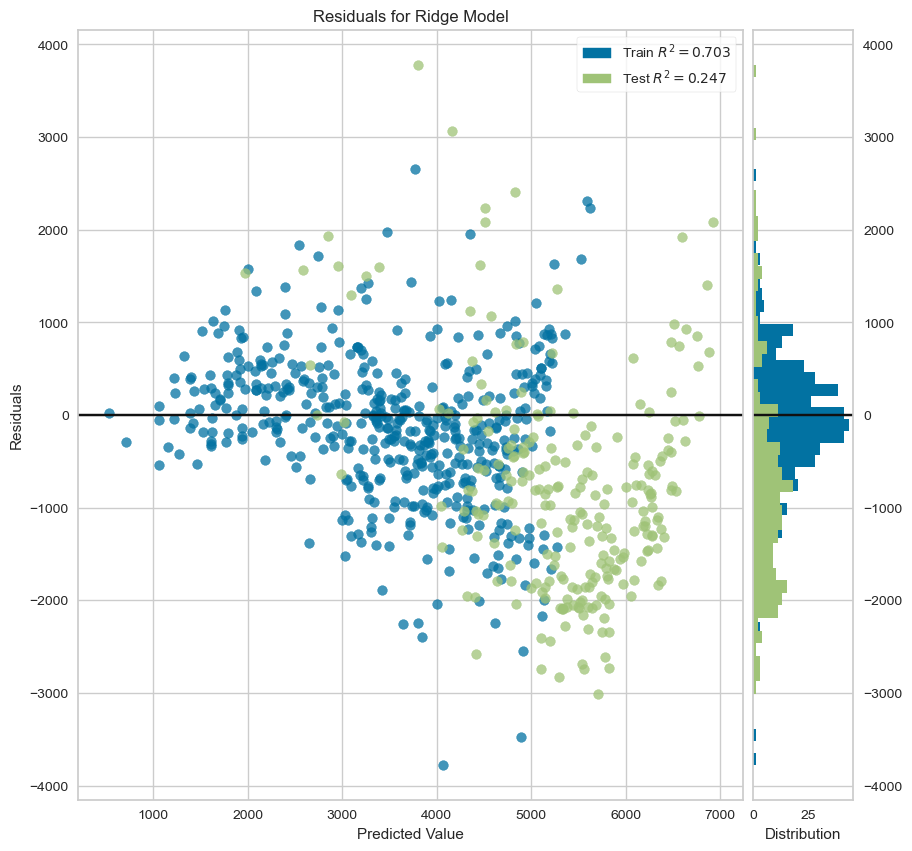

In [23]:
viz = residuals_plot(model, x_train_total, y_train_total, x_test, y_test)


Plot prediction vs observation

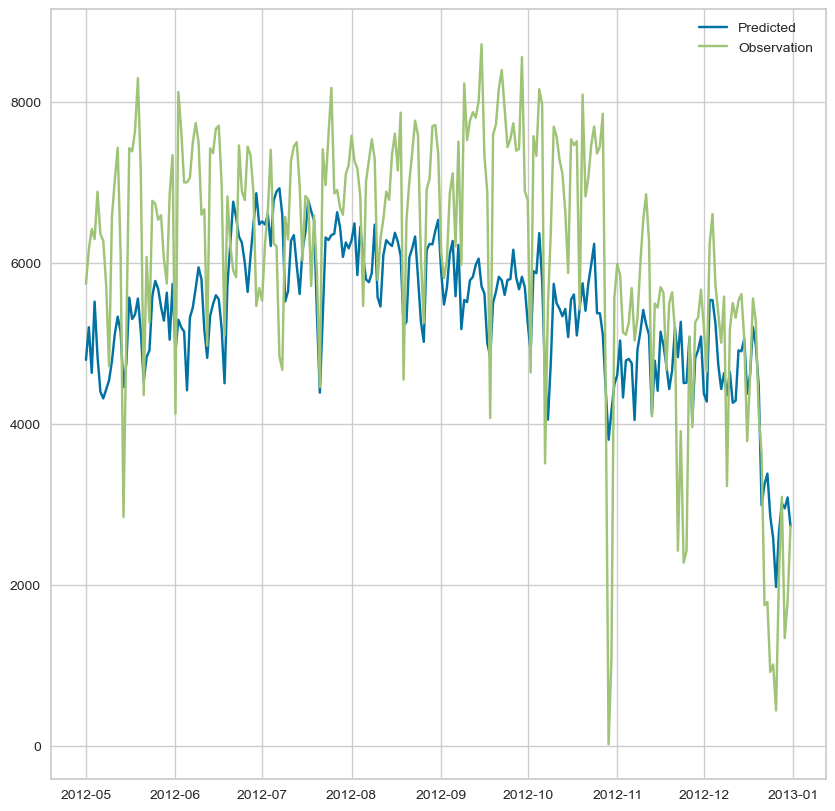

In [24]:
y_pred=model.predict(x_test)
plt.plot(x_test.index,y_pred)
plt.plot(x_test.index,y_test)
plt.legend(['Predicted', 'Observation'])
plt.show()

VIF to check the colinearity of variables

In [25]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,hum,24.13
0,season,21.06
2,mnth,15.09
6,weathersit,12.58
7,temp,8.94
9,windspeed,5.64
5,workingday,3.30
4,weekday,3.14
1,yr,1.44
3,holiday,1.11


Let's remove hum

MAE is 1125.5854
R square is 0.8649
MAE is 625.6446
R square is 0.8100
MAE is 553.3342
R square is 0.7818
MAE is 1356.4406
R square is 0.7582
MAE is 1235.0701
R square is 0.7538


<module 'matplotlib.pyplot' from '/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

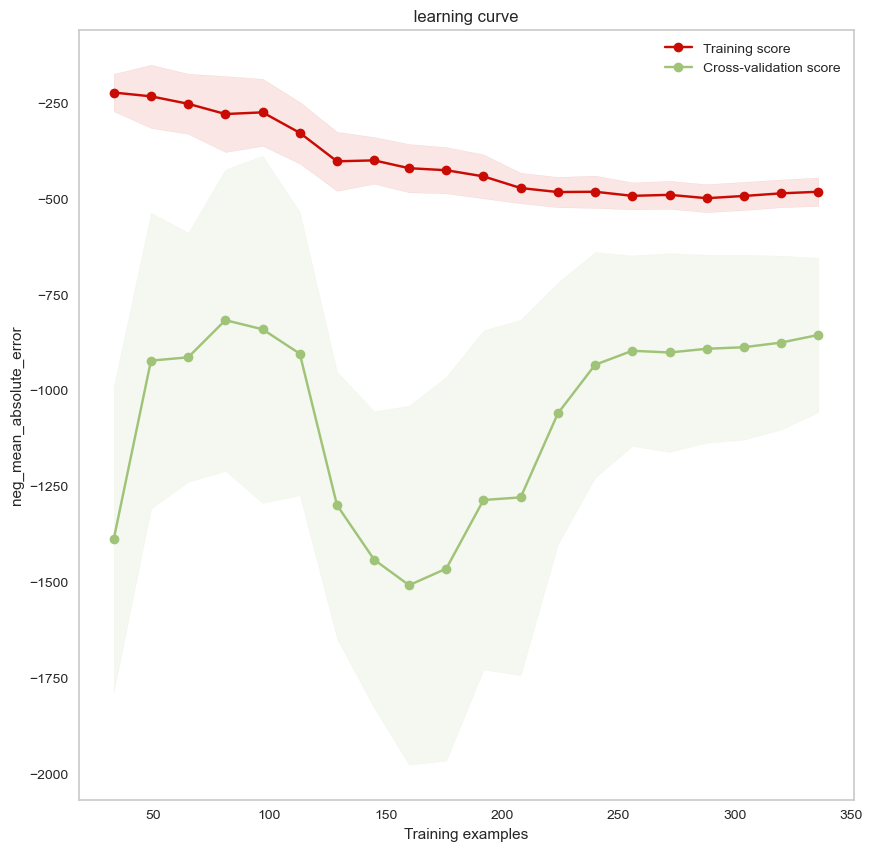

In [26]:
df_r=df_r.drop('hum',axis=1)
train=df_r[df_r.index < '05-01-2012']
test= df_r[df_r.index >= '05-01-2012']

cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    y_train=train_valid['cnt']
    y_val=validation['cnt']
    x_train=train_valid.drop('cnt', axis=1)
    x_val=validation.drop('cnt', axis=1)
    model=LinearRegression()
    model.fit(x_train, y_train)
    print('MAE is {}'.format('%.4f' %mean_absolute_error(y_val, model.predict(x_val)) ))
    print('R square is {}'.format('%.4f' %model.score(x_train,y_train)))

plot_learning_curve(estimator = model,title = " learning curve ",X = x_train, y = y_train, cv = 5)

In [27]:
x_train_total=train.drop('cnt', axis=1)
y_train_total=train['cnt']
x_test=test.drop('cnt',axis=1)
y_test=test['cnt']
model.fit(x_train, y_train)
print('MAE is {}'.format('%.4f' %mean_absolute_error(y_test, model.predict(x_test)) ))
print('R square of traing data is {}'.format('%.4f' %model.score(x_train_total,y_train_total)))
print('R square of test data is {}'.format('%.4f' %r2_score(y_test, model.predict(x_test))))

MAE is 1137.4755
R square of traing data is 0.7120
R square of test data is 0.2981


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


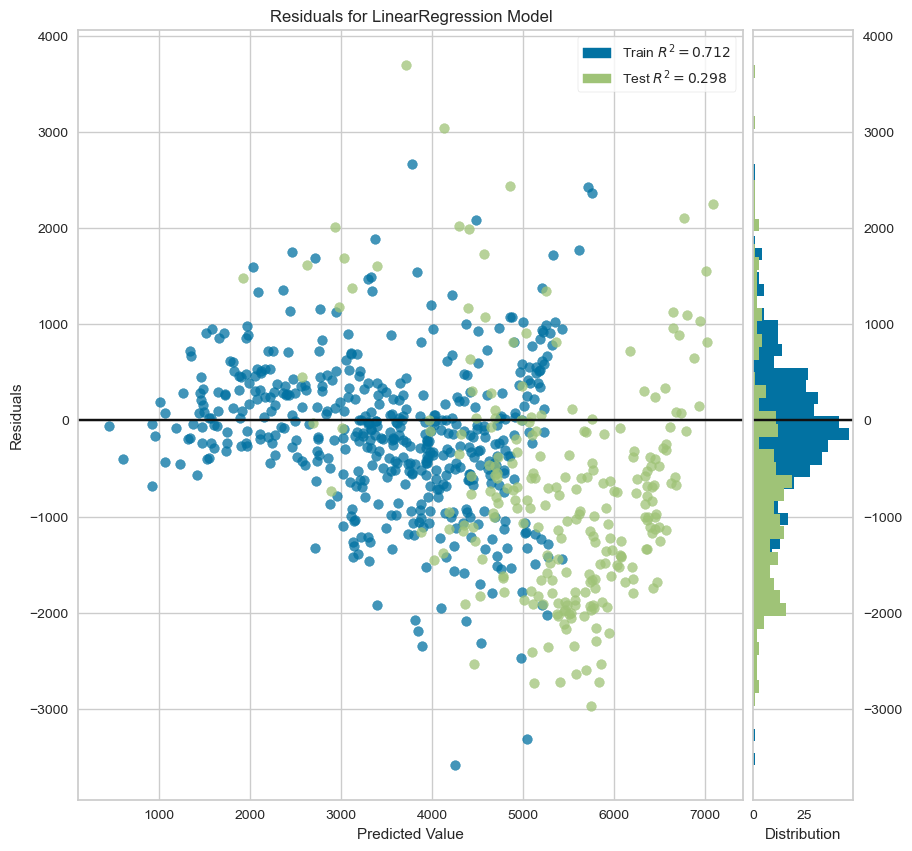

In [28]:
viz = residuals_plot(model, x_train_total, y_train_total, x_test, y_test)


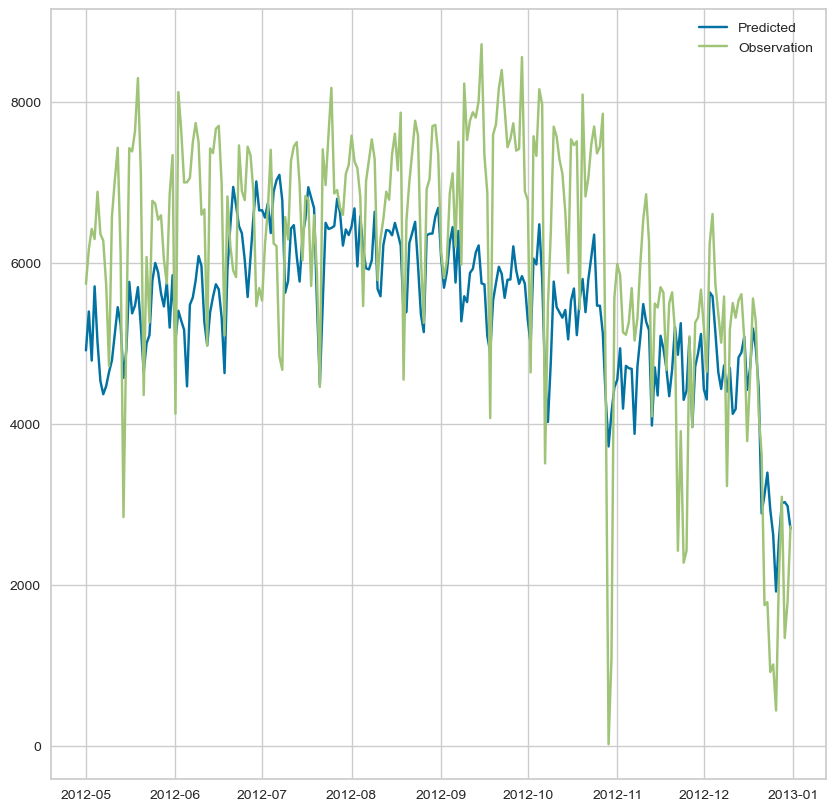

In [29]:
y_pred=model.predict(x_test)
plt.plot(x_test.index,y_pred)
plt.plot(x_test.index,y_test)
plt.legend(['Predicted', 'Observation'])
plt.show()

check VIF again

In [30]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,season,20.86
2,mnth,14.89
7,temp,7.62
6,weathersit,6.32
8,windspeed,5.61
5,workingday,3.27
4,weekday,3.12
1,yr,1.36
3,holiday,1.11


Let's remove season

MAE is 1029.7807
R square is 0.8598
MAE is 623.6662
R square is 0.8099
MAE is 562.6210
R square is 0.7817
MAE is 1414.9705
R square is 0.7571
MAE is 1246.2983
R square is 0.7319


<module 'matplotlib.pyplot' from '/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

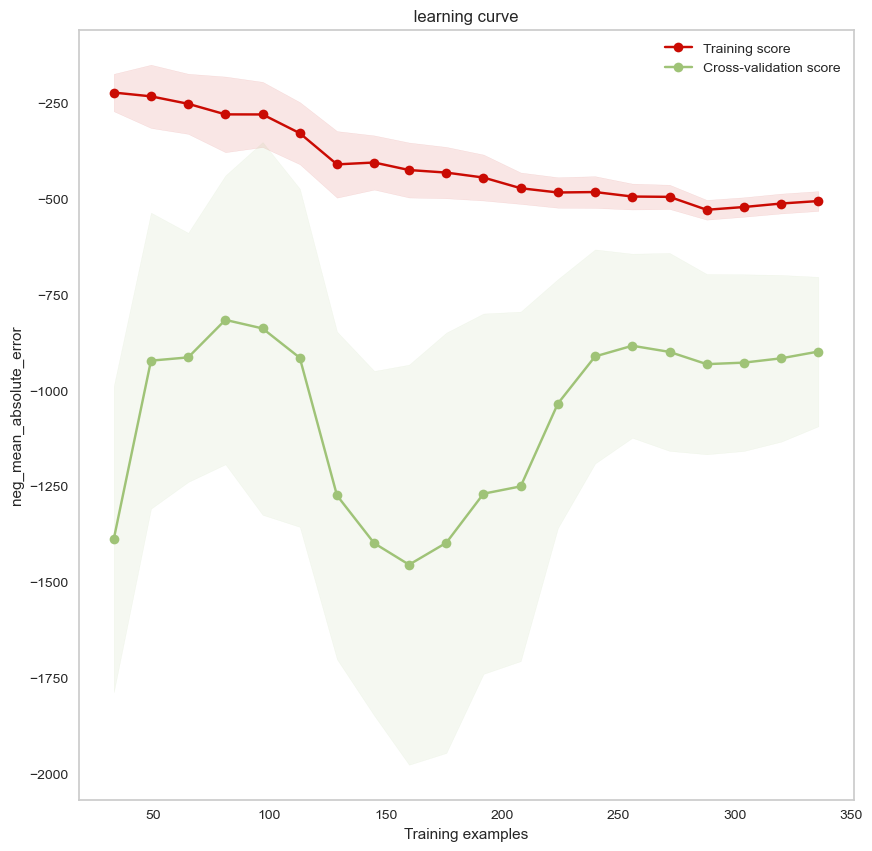

In [31]:
df_r=df_r.drop('season',axis=1)
train=df_r[df_r.index < '05-01-2012']
test= df_r[df_r.index >= '05-01-2012']

cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    y_train=train_valid['cnt']
    y_val=validation['cnt']
    x_train=train_valid.drop('cnt', axis=1)
    x_val=validation.drop('cnt', axis=1)
    model=LinearRegression()
    model.fit(x_train, y_train)
    print('MAE is {}'.format('%.4f' %mean_absolute_error(y_val, model.predict(x_val)) ))
    print('R square is {}'.format('%.4f' %model.score(x_train,y_train)))

plot_learning_curve(estimator = model,title = " learning curve ",X = x_train, y = y_train, cv = 5)

In [32]:
x_train_total=train.drop('cnt', axis=1)
y_train_total=train['cnt']
x_test=test.drop('cnt',axis=1)
y_test=test['cnt']
model.fit(x_train, y_train)
print('MAE is {}'.format('%.4f' %mean_absolute_error(y_test, model.predict(x_test)) ))
print('R square of traing data is {}'.format('%.4f' %model.score(x_train_total,y_train_total)))
print('R square of test data is {}'.format('%.4f' %r2_score(y_test, model.predict(x_test))))

MAE is 1209.7938
R square of traing data is 0.6932
R square of test data is 0.2178


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


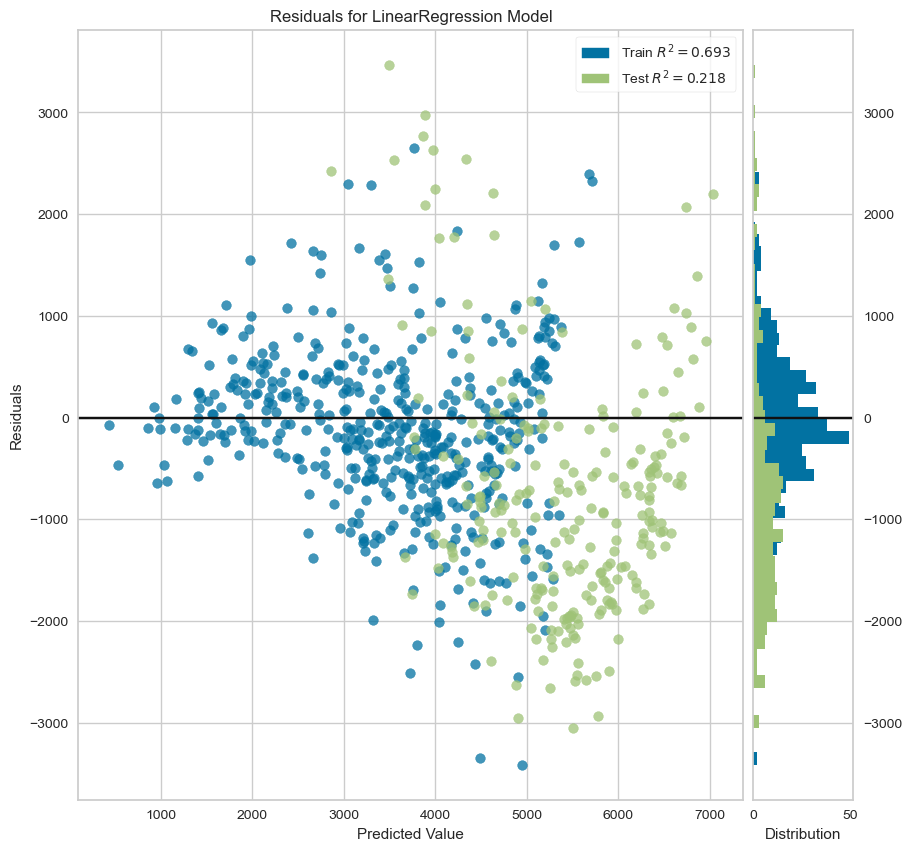

In [33]:
viz = residuals_plot(model, x_train_total, y_train_total, x_test, y_test)


Check VIF again

In [34]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,temp,6.70
5,weathersit,6.17
7,windspeed,5.60
1,mnth,4.71
4,workingday,3.27
3,weekday,3.12
0,yr,1.36
2,holiday,1.11


Let's try polynomial regresion

1486.2630394039684
617.4928965848648
950.1531281656298
1756.2664176462265
1056.4317866493568


<module 'matplotlib.pyplot' from '/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

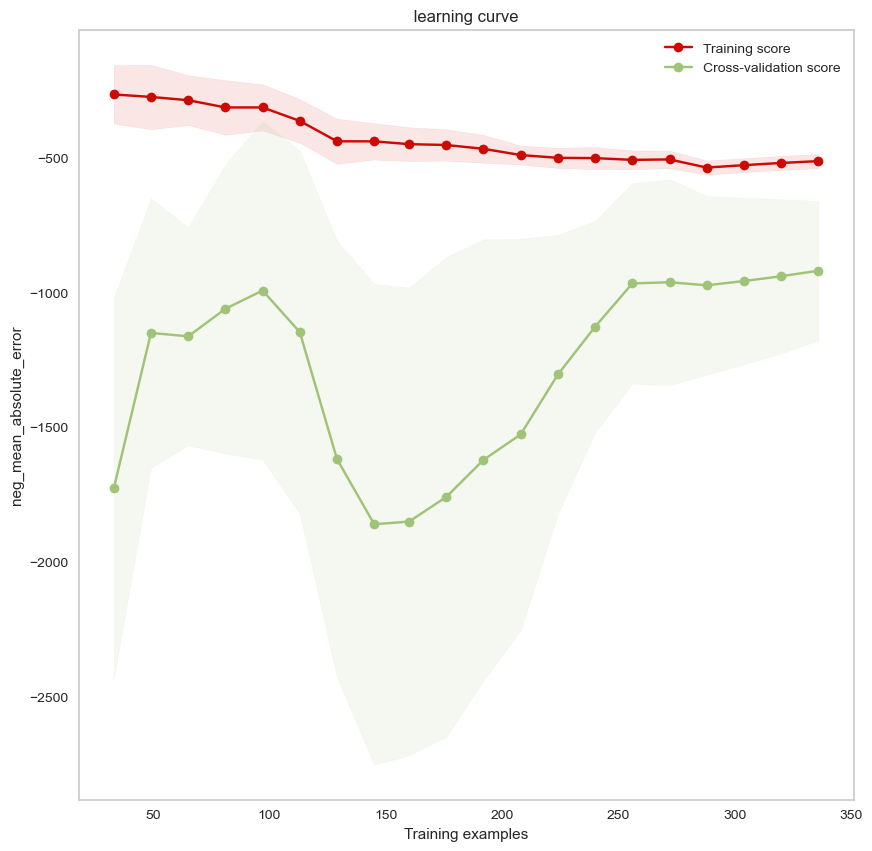

In [35]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=df_r.iloc[train_in]
    validation=df_r.iloc[val_in]
    y_train=train_valid['cnt']
    y_val=validation['cnt']
    x_train=train_valid.drop('cnt', axis=1)
    x_val=validation.drop('cnt', axis=1)
    model_poly=PolynomialFeatures(degree=2)
    x_pl=model_poly.fit_transform(x_train)
    x_pl_val=model_poly.fit_transform(x_val)
    model_poly=Ridge()
    model_poly.fit(x_pl, y_train)
    y_pred=model_poly.predict(x_pl_val)
    print(mean_absolute_error(y_val, y_pred))
 
plot_learning_curve(estimator = model_poly,title = " learning curve ",X = x_train, y = y_train, cv = 5)


In [36]:
x_train_total=train.drop('cnt', axis=1)
y_train_total=train['cnt']
x_test=test.drop('cnt',axis=1)
y_test=test['cnt']
model_poly=PolynomialFeatures(degree=2)
x_pl=model_poly.fit_transform(x_train_total)
x_pl_test=model_poly.fit_transform(x_test)
model_poly=Ridge()
model_poly.fit(x_pl, y_train_total)
y_pred=model_poly.predict(x_pl_test)
print(mean_absolute_error(y_test, y_pred))
print('R square of test data is {}'.format('%.4f' %r2_score(y_test, y_pred)))

1198.1507523810055
R square of test data is 0.0577


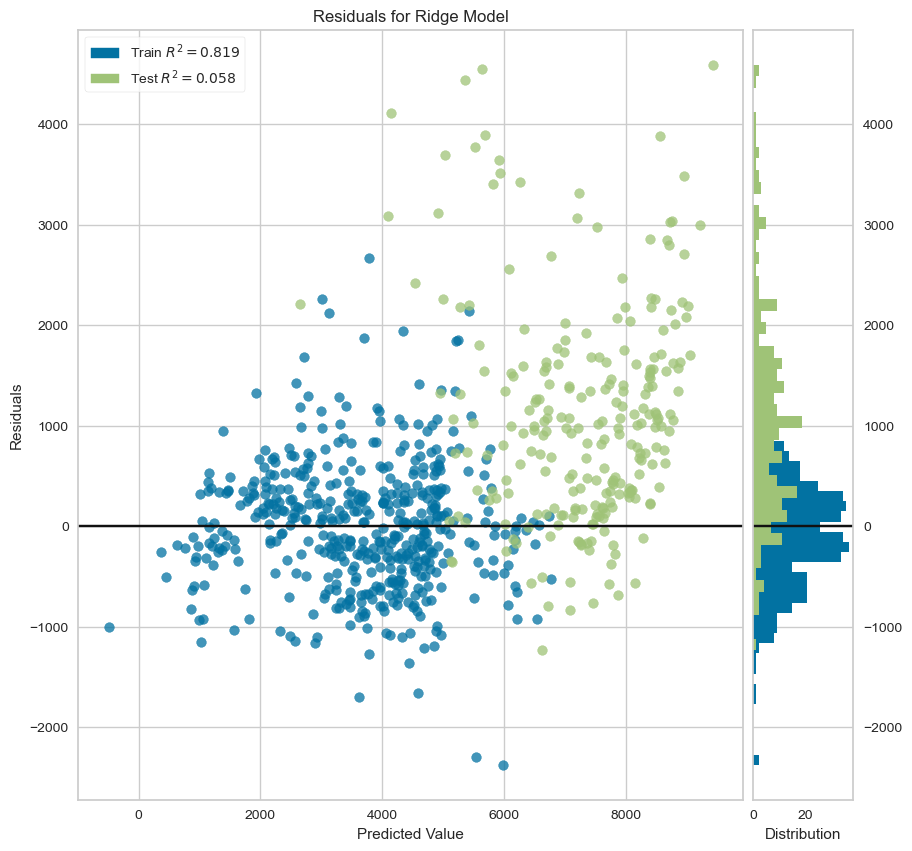

In [37]:
viz = residuals_plot(model_poly, x_pl, y_train_total, x_pl_test, y_test)


Plot prediction vs observation

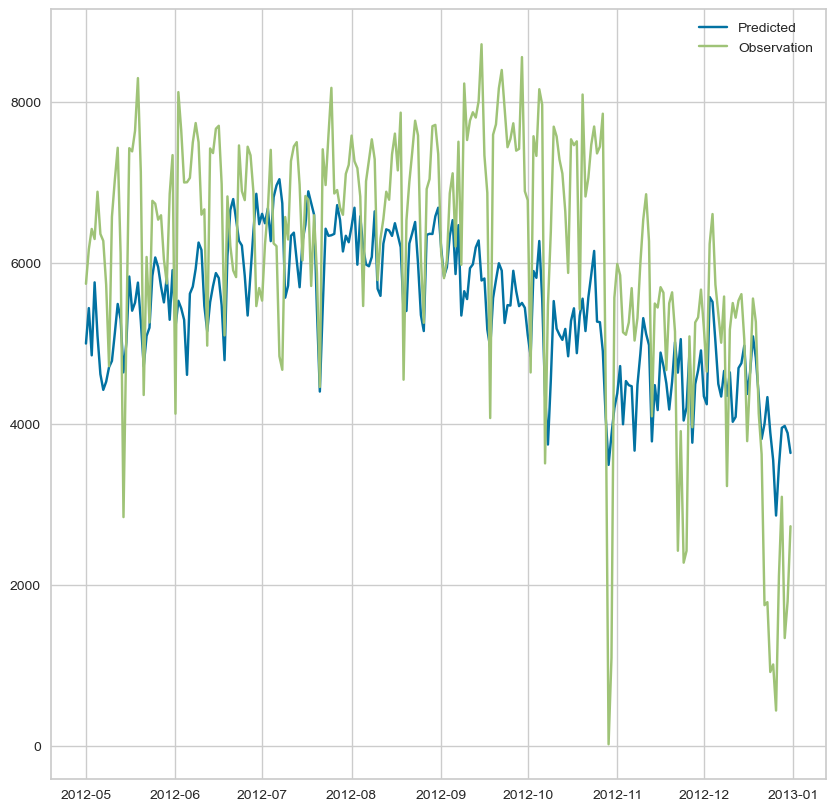

In [38]:
y_pred=model.predict(x_test)
plt.plot(x_test.index,y_pred)
plt.plot(x_test.index,y_test)
plt.legend(['Predicted', 'Observation'])
plt.show()